In [1]:
# Cell 1: Enable interactive backend and import libraries
%matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Cell 2: Create the sample DataFrame
data = {
    'Time': np.arange(0, 20, 1),
    'Temperature': 50 + 2 * np.arange(0, 20, 1) + np.random.randn(20) * 3
}
# Add a few outlier points to make it interesting
data['Temperature'][4] = 75
data['Temperature'][15] = 40
df = pd.DataFrame(data)

# IMPORTANT: Sort the dataframe by the x-axis for interpolation to work correctly.
df = df.sort_values(by='Time').reset_index(drop=True)

# We will keep a copy of the original to compare against later
original_df = df.copy()

print("--- Original DataFrame ---")
print(original_df)

--- Original DataFrame ---
    Time  Temperature
0      0    49.570851
1      1    54.528362
2      2    55.033263
3      3    58.070515
4      4    75.000000
5      5    58.941046
6      6    59.713064
7      7    62.617712
8      8    68.076632
9      9    70.199566
10    10    67.363472
11    11    73.663317
12    12    76.192893
13    13    77.283464
14    14    70.664215
15    15    40.000000
16    16    79.723508
17    17    84.613781
18    18    83.513697
19    19    91.890985


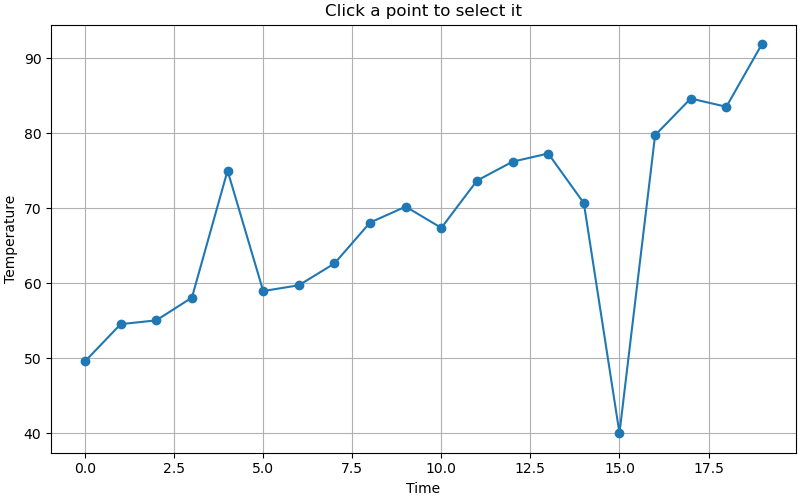

In [3]:
# Cell 3: The main interactive plotter class
class JupyterPlotEditor:
    def __init__(self, df, x_col, y_col):
        self.df = df
        self.x_col = x_col
        self.y_col = y_col
        self.selected_index = None

        # --- Create Matplotlib plot objects ---
        # The plt.subplots() call creates the figure in the notebook output
        self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
        self.line, = self.ax.plot(self.df[self.x_col], self.df[self.y_col], 'o-', picker=5) # picker=5 enables clicks
        self.ax.set_xlabel(self.x_col)
        self.ax.set_ylabel(self.y_col)
        self.ax.set_title("Click a point to select it")
        self.ax.grid(True)
        
        # --- Create ipywidgets ---
        self.delete_button = widgets.Button(description="Delete Point", disabled=True)
        self.interpolate_button = widgets.Button(description="Interpolate Point", disabled=True)
        self.status_label = widgets.Label(value="No point selected.")
        
        # --- Connect event handlers ---
        self.fig.canvas.mpl_connect('pick_event', self.on_pick)
        self.delete_button.on_click(self.on_delete_click)
        self.interpolate_button.on_click(self.on_interpolate_click)
        
        # --- Display widgets ---
        # The plot is already displayed by plt.subplots()
        # We just need to display the controls below it
        controls = widgets.HBox([self.delete_button, self.interpolate_button, self.status_label])
        display(controls)

    def on_pick(self, event):
        """Handles the selection of a data point on the plot."""
        if len(event.ind) > 0:
            self.selected_index = event.ind[0]
            val_x = self.df.iloc[self.selected_index][self.x_col]
            val_y = self.df.iloc[self.selected_index][self.y_col]
            
            # Update status label and enable buttons
            self.status_label.value = f"Selected Index: {self.selected_index} (Value: {val_x:.2f}, {val_y:.2f})"
            self.delete_button.disabled = False
            
            # Disable interpolate button if it's an endpoint
            is_endpoint = (self.selected_index == 0 or self.selected_index == len(self.df) - 1)
            self.interpolate_button.disabled = is_endpoint
    
    def update_plot(self):
        """Redraws the plot with the new data from the DataFrame."""
        # Update the x and y data of the line object
        self.line.set_xdata(self.df[self.x_col])
        self.line.set_ydata(self.df[self.y_col])
        
        # Rescale the axes to fit the new data
        self.ax.relim()
        self.ax.autoscale_view()
        
        # Redraw the canvas
        self.fig.canvas.draw_idle()
        print("\nPlot updated.")

    def on_delete_click(self, b):
        """Deletes the selected point and updates the plot."""
        if self.selected_index is not None:
            print(f"Deleting point at index {self.selected_index}.")
            self.df.drop(self.selected_index, inplace=True)
            self.df.reset_index(drop=True, inplace=True)
            self.reset_selection()
            self.update_plot()

    def on_interpolate_click(self, b):
        """Interpolates the selected point and updates the plot."""
        if self.selected_index is not None:
            print(f"Interpolating point at index {self.selected_index}.")
            prev_point = self.df.iloc[self.selected_index - 1]
            next_point = self.df.iloc[self.selected_index + 1]
            target_x = self.df.iloc[self.selected_index][self.x_col]
            
            # Use NumPy for linear interpolation
            new_y = np.interp(target_x, [prev_point[self.x_col], next_point[self.x_col]], [prev_point[self.y_col], next_point[self.y_col]])
            
            self.df.loc[self.selected_index, self.y_col] = new_y
            self.reset_selection()
            self.update_plot()

    def reset_selection(self):
        """Resets the selection state and disables buttons."""
        self.selected_index = None
        self.status_label.value = "Action complete. Select a new point."
        self.delete_button.disabled = True
        self.interpolate_button.disabled = True

# --- Instantiate the class to run the application ---
plot_editor = JupyterPlotEditor(df, x_col='Time', y_col='Temperature')

In [5]:
!conda update -c conda-forge jupyterlab ipympl

Retrieving notices: ...working... done

PackageNotInstalledError: Package is not installed in prefix.
  prefix: /Users/bell/mambaforge/envs/earthdata
  package name: jupyterlab


